In [1]:
from Utils import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import os.path


In [2]:
coupling_type = '1JHN'
XY_Data = pd.read_csv(f'{Config.INPUT_XY}/{coupling_type}.csv', index_col=0)

In [3]:
XY_Data.describe()

,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,r_x_1,r_x_2,...,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3,scalar_coupling_constant
count,24173.000000,24173.000000,24173.000000,24173.000000,24173.000000,24173.000000,24173.000000,24173.000000,24173.000000,24173.000000,...,24173.000000,24173.000000,24173.000000,24173.000000,24173.000000,24173.000000,24173.000000,24173.000000,24173.000000,24173.000000
mean,4.153187,5.967608,4.059860,4.333802,4.540272,4.758532,4.571878,4.114094,-0.506323,-1.014087,...,2.307700,3.623208,3.102682,3.055215,2.559309,3.883553,3.376286,3.319870,2.819330,47.502928
std,2.437619,1.101194,2.988535,2.822509,2.711743,2.523229,2.614864,2.769612,0.002889,0.142719,...,0.730456,0.665466,0.616922,0.989697,0.747755,0.740371,0.688237,1.033087,0.767489,10.469338
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.571039,-1.446975,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.981600
25%,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-0.508674,-1.094137,...,1.552639,3.170414,2.587851,2.378674,2.175278,3.331194,2.865301,2.503632,2.257383,36.776200
50%,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,-0.506012,-0.988436,...,2.279570,3.547872,3.010706,2.900837,2.487185,3.889885,3.334797,3.262163,2.660696,48.112800
75%,6.000000,6.000000,7.000000,6.000000,6.000000,6.000000,6.000000,6.000000,-0.503818,-0.929913,...,2.708063,4.110631,3.576799,3.936680,2.927190,4.374574,3.710396,4.102629,3.312572,57.102900
max,7.000000,8.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,-0.501178,-0.736466,...,5.402533,6.975702,5.983036,6.975702,5.402954,8.397549,7.400241,8.397549,6.675676,79.367000


In [4]:
def get_filtered_errors(coupling_type):
    filterFile = f'{Config.INPUT_XY_FILTER}/{coupling_type}.csv'
    isFilter = os.path.exists(filterFile)
    if  not isFilter:
        dpOldErr = None
    else:
        dpOldErr = pd.read_csv(f'{Config.INPUT_XY_FILTER}/{coupling_type}.csv', index_col=0)
    return dpOldErr

In [5]:
def get_filtered_xy(dpOldErr):
    if dpOldErr is None:
        XY_Filtered = XY_Data
    else:    
        mask = XY_Data.index.isin(dpOldErr.index)
        mask = np.invert(mask)
        XY_Filtered = XY_Data.loc[mask]
        XY_Filtered.describe()
    return XY_Filtered

dpOldErr = get_filtered_errors(coupling_type)
XY_Filtered = get_filtered_xy(dpOldErr)

In [6]:
X_data, y_data = build_x_y_data(XY_Filtered)
#X_data, y_data
#X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.3, random_state=228)

In [7]:
%time 
X_train = X_data
X_val =  X_data
y_train = y_data
y_val = y_data
categorical_features = [col for col in X_train if col.startswith('atom_')]

#X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.3, random_state=228)
# to record eval results for plotting
model = LGBMRegressor(**Config.LGB_PARAMS, n_estimators=500, n_jobs = -1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        verbose=100, early_stopping_rounds=1000,
         categorical_feature = categorical_features)

y_pred = model.predict(X_val)
print(mean_absolute_error(y_val, y_pred))
np.log(mean_absolute_error(y_val, y_pred))


Wall time: 0 ns
Training until validation scores don't improve for 1000 rounds.


C:\ProgramFiles\Anaconda\lib\site-packages\lightgbm\basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['atom_2', 'atom_3', 'atom_4', 'atom_5', 'atom_6', 'atom_7', 'atom_8', 'atom_9']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[100]	training's l1: 0.418703
[200]	training's l1: 0.323595
[300]	training's l1: 0.275192
[400]	training's l1: 0.244059
[500]	training's l1: 0.22102
Did not meet early stopping. Best iteration is:
[500]	training's l1: 0.22102
0.22102005177079137


-1.5095018495857515

In [8]:
#dpNewErr.to_csv(f'{Config.INPUT_XY_FILTER}/{coupling_type}2.csv')

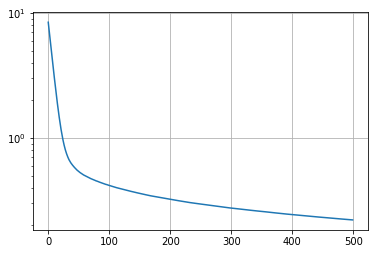

In [9]:
eval_results = model.evals_result_
l1 = eval_results["training"]["l1"]
plt.plot(l1)

#valid = eval_results["valid_1"]["l1"]
#plt.plot(valid)

#ax.set_yticks(np.linspace(100, 1000, 10))
plt.yscale('log')
plt.grid(True)

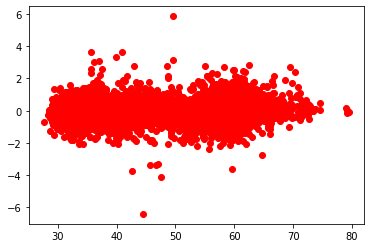

In [10]:
X_non_filter = X_train
y_non_filter = y_train
y_n_pred = model.predict(X_non_filter)
plt.plot(y_n_pred, y_non_filter - y_n_pred, 'ro')

In [11]:
err = abs(y_non_filter - y_n_pred)
_, up_err = np.percentile(err, [0,99.9])
dp = y_non_filter.to_frame()
dp['err'] = pd.Series(err)
dp.describe()

,scalar_coupling_constant,err
count,24073.000000,24073.000000
mean,47.494613,0.221020
std,10.468796,0.273498
min,26.981600,0.000029
25%,36.763100,0.064619
50%,48.106700,0.143174
75%,57.100400,0.272407
max,79.367000,6.409141


In [12]:
dpNewErr = dp[dp.err >= up_err]
dpNewErr.describe()

,scalar_coupling_constant,err
count,25.000000,25.000000
mean,49.538076,3.331917
std,10.289190,0.954253
min,38.093700,2.541142
25%,40.094100,2.755707
50%,44.556100,3.057811
75%,57.746700,3.625030
max,72.192700,6.409141


In [13]:
if dpOldErr is None:
    dfErr = dpNewErr
else:
    dfErr = pd.concat([dpOldErr,dpNewErr])
dfErr.to_csv(f'{Config.INPUT_XY_FILTER}/{coupling_type}.csv')

In [14]:
dpOldErr.describe()

,scalar_coupling_constant,err
count,100.000000,100.000000
mean,49.504633,4.407195
std,10.459874,2.336427
min,30.341100,2.785223
25%,40.442000,3.179081
50%,48.571550,3.574001
75%,57.929750,4.628960
max,71.651600,17.998343
